In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.utils.data
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch import Tensor as T

In [16]:
class VAE(nn.Module):
    def __init__(self, bottleneck=5):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, bottleneck)
        self.fc22 = nn.Linear(400, bottleneck)
        self.fc3 = nn.Linear(bottleneck, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def forward(angles, armlengths=None):
    if armlengths is None:
        armlengths = np.ones_like(angles)
    else:
        assert len(angles) == len(armlengths)
    coords = [(0, 0)]
    for angle, bone in zip(angles, armlengths):
        offs = coords[-1]
        coords += [(bone * np.cos(angle) + offs[0],
                               bone *  np.sin(angle) + offs[1])]
    return coords

In [5]:
def plot_keypoints(coords):
    for i, (x, y) in enumerate(coords):
        plt.scatter(x, y)
    plt.legend(range(len(coords)))
    plt.grid()
    plt.ylim((-2, 2))
    plt.xlim((-2, 2))
    plt.show()

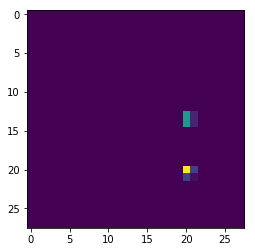

In [80]:
def keypoint_to_image(coords, size=(28, 28)):
    img = np.zeros(size)
    t1 = np.linspace(-2, 2, size[0])
    t2 = np.linspace(-2, 2, size[1])
    X, Y = np.meshgrid(t1, t2)
    for x, y in coords[1:]:
        img = img + np.exp(-150*((x-X)**2+(y-Y)**2))
    return img

plt.imshow(keypoint_to_image(forward([0, np.pi/2])))

In [81]:
a, b = (np.random.rand(2)+1)/2
print(a, b)
labels = 2*np.pi*(np.random.rand(600000, 2)-0.5)

0.8172069607006394 0.613370441723601


(600000, 1, 28, 28)


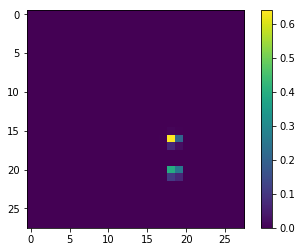

In [82]:
imgs = np.empty((len(labels), 1, 28, 28))
for i, angles in enumerate(labels):
    alpha, beta = angles
    coords = forward([alpha, beta], [a, b])
    imgs[i, 0] = keypoint_to_image(coords)
print(imgs.shape)

plt.imshow(imgs[42, 0]); plt.colorbar()
# plot_keypoints(coords)

In [83]:
batch_size = 128
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx in range(2+len(labels)//batch_size):
        if (batch_idx+1)*batch_size > len(imgs):
            batch = imgs[batch_idx*batch_size:]
            break
        else:
            batch = imgs[batch_idx*batch_size:(batch_idx+1)*batch_size]
        data = T(batch).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, 
                loss.item() / len(data)))

In [84]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [90]:
device = torch.device("cuda")
bottleneck = 10
model = VAE(bottleneck=bottleneck).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [91]:
for i in range(5):
    train(i)

Train Epoch: 0 	Loss: 552.300354
Train Epoch: 0 	Loss: 21.759485
Train Epoch: 0 	Loss: 17.909348
Train Epoch: 0 	Loss: 16.267822
Train Epoch: 0 	Loss: 15.358476
Train Epoch: 0 	Loss: 14.674406
Train Epoch: 0 	Loss: 14.124195
Train Epoch: 0 	Loss: 12.979056
Train Epoch: 0 	Loss: 13.201703
Train Epoch: 0 	Loss: 12.759495
Train Epoch: 0 	Loss: 12.450727
Train Epoch: 0 	Loss: 12.138077
Train Epoch: 0 	Loss: 11.996571
Train Epoch: 0 	Loss: 12.151214
Train Epoch: 0 	Loss: 11.714491
Train Epoch: 0 	Loss: 11.936572
Train Epoch: 0 	Loss: 11.556945
Train Epoch: 0 	Loss: 11.688791
Train Epoch: 0 	Loss: 11.646399
Train Epoch: 0 	Loss: 11.579462
Train Epoch: 0 	Loss: 11.541948
Train Epoch: 0 	Loss: 11.294346
Train Epoch: 0 	Loss: 11.410301
Train Epoch: 0 	Loss: 11.257204
Train Epoch: 0 	Loss: 11.331065
Train Epoch: 0 	Loss: 11.219203
Train Epoch: 0 	Loss: 11.189768
Train Epoch: 0 	Loss: 11.472795
Train Epoch: 0 	Loss: 11.362240
Train Epoch: 0 	Loss: 11.341043
Train Epoch: 0 	Loss: 11.396503
Train E

In [92]:
with torch.no_grad():
    sample = torch.randn(9, bottleneck).to(device)
    sample = model.decode(sample).cpu()

In [93]:
from itertools import product
to_ind = np.array(list(product(range(3), range(3))))

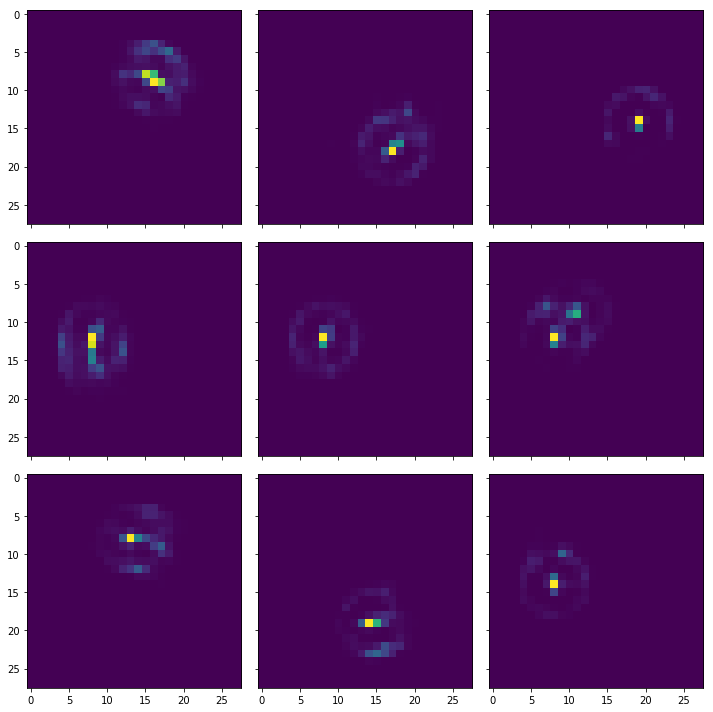

In [94]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches((10, 10))
for i, img in enumerate(np.array(sample)):
    ind = to_ind[i]
    ax[ind[0], ind[1]].imshow(img.reshape(28, 28))
plt.tight_layout()
plt.show()